# Ripple phase modulation

In [1]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
import glob as glob
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
import itertools
from scipy import stats

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import phase_by_time

from pycircstat import descriptive as desc
from pycircstat import distributions as dist
from pycircstat import tests as circ_test

from matplotlib import gridspec
import matplotlib as mpl


Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

## Load data

In [3]:
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
save_path = "F:/Projects/PAE_PlaceCell/analysis/ripple_modulation_phase/"
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\pyr_int_df.csv')
display(df_cell_class)


df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')
display(df)


,Unnamed: 0,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,acg_refrac,...,trough,spkW,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type,area
0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,3.757487,...,-2.393640,0.777777,0.021529,1.149097,1.535871,2.529014,3.181064,7340,pyr,ca1
1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,7.293023,...,-2.027969,0.930761,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr,ca1
2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,4.657924,...,-2.491995,0.777777,0.041928,1.235779,1.773778,2.580697,3.908416,7490,pyr,ca1
3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,1.285490,...,-2.784299,0.571703,0.000555,1.032228,0.999013,0.621228,3.730098,1803,pyr,ca1
4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,4.588725,...,-2.683800,0.684153,0.011062,0.983793,1.406165,2.959360,3.743105,8589,pyr,ca1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,8777,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,3.311529,0.086722,...,-2.886261,0.529358,0.000000,1.059228,5.973929,0.789008,4.629547,1252,pyr,ca1
8778,8778,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,12.260592,0.000135,...,-3.028445,0.271706,0.004489,0.735687,23.134516,13.056442,2.818769,20718,int,ca1
8779,8779,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,3.685590,0.000087,...,-2.461559,0.286010,0.000000,0.955257,6.281825,0.626417,21.188431,994,int,ca1
8780,8780,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,9.395189,0.011953,...,-2.361157,0.701930,0.021382,0.999326,31.814075,1.533272,2.350860,2433,pyr,ca1


,Unnamed: 0,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,area,ep_type,group,rat
0,0,22,211.247200,211.327200,0.080000,0.990871,211.296000,3,5.566472,213.605249,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
1,1,60,517.919200,518.311200,0.392000,0.995188,518.087200,7,29.168512,203.155556,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
2,2,72,607.938400,608.326400,0.388000,0.990928,607.964000,3,7.932019,103.616382,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
3,3,80,675.985600,676.139200,0.153600,0.994272,676.074400,7,5.077734,173.913383,0.000000,LEM3116_S20180715121821,ca1,track,control,LEM3116
4,4,100,933.226400,933.424000,0.197600,0.992893,933.278400,7,27.285162,119.721685,0.000000,LEM3116_S20180715121821,ca1,pedestal_2,control,LEM3116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18199,18728,25,255.450400,255.599200,0.148800,0.314032,255.533600,7,8.094016,105.746020,0.000000,RH16_S20161126145021,ca1,track,pae,RH16
18200,18729,22,149.384000,149.505600,0.121600,0.133732,149.436800,6,12.060743,186.017137,0.000000,RH16_S20161126150318,ca1,track,pae,RH16
18201,18730,32,233.419200,233.576000,0.156800,0.260312,233.496000,7,8.145433,110.793201,0.000000,RH16_S20161126150318,ca1,track,pae,RH16
18202,18731,36,270.288000,270.410400,0.122400,0.065024,270.328800,0,4.390508,174.380797,0.000000,RH16_S20161126150318,ca1,track,pae,RH16


In [4]:
waveforms = np.load(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\waves_zscore.npy')
acg = np.load(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\acg_narrow.npy')

In [5]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def smoothAngularTuningCurves(tuning_curve,deviation=3):
    n_bins = len(tuning_curve)
    padded = np.hstack([tuning_curve,tuning_curve,tuning_curve])
    padded = gaussian_filter1d(padded, deviation)
    return padded[n_bins:n_bins+n_bins]

def circ_interp(x1,theta,x2):
    '''
    Input:
        x1: linear x variable
        theta: angles in radians; same len as x1
        x2: new linear x variable 
    Output:
        new theta (-pi to pi)
    '''
    # polar to cartesian, then interp, then cartesian to polar
    new_theta = np.arctan2(np.interp(x2,x1,np.sin(theta)), np.interp(x2,x1,np.cos(theta)))
    # wrap -pi to pi and return
    return (new_theta + np.pi) % (2 * np.pi) - np.pi

    
def spike_phase_maps(spikes,phase,ts,df,session,fs=1250,n_bins=60,window=0.1):

    bin_edges = np.linspace(-np.pi,np.pi,n_bins+1)
    bin_width = np.diff(bin_edges)[0]
    bin_centers = np.linspace(-np.pi+bin_width/2 ,np.pi-bin_width/2, n_bins)
    
    # loop through spikes
    spk_phase_all = []
    phase_counts = []
    binned_phase = []
    smoothed_phase = []
    peak_phase = []
    spk_count = []
    resultant = []
    kappa = []
    rayleigh_z = []
    rayleigh_pval = []
    
    for i,spk in enumerate(spikes):
#         print('cell: ',i)
        spk_phase = []
        occ_phase = []
        for ripple in df[df.session == session].itertuples():
            # restrict spikes to current ripple
            current_spikes = spk[(spk >= ripple.peak_time - window) & (spk <= ripple.peak_time + window)]
            # collect interp phase for each spike
            spk_phase.append(circ_interp(ts,phase[:,int(ripple.peak_channel)],current_spikes))
            # collect occ phases for normalization
            occ_phase.append(phase[(ts >= ripple.peak_time - window) & (ts <= ripple.peak_time + window),int(ripple.peak_channel)])

        # flatten phases into nice list    
        x = list(itertools.chain(*spk_phase)) 
        x2 = list(itertools.chain(*occ_phase))    
        # bin from -pi to pi
        y, _ = np.histogram(x, bins=bin_edges)
        y2, _ = np.histogram(x2, bins=bin_edges)
        
        # convert to firing rate in Hz
        tuning = y / (y2 / fs)
        
        # smooth and find max phase
        smooth_y = smoothAngularTuningCurves(tuning)
        max_phase = bin_centers[np.argmax(smooth_y)]
        
        pval, z = circ_test.rayleigh(bin_centers, w=smooth_y, d=bin_width)

        n_spikes = y.sum()
        
        # append for each cell
        spk_phase_all.append(x)
        phase_counts.append(y)
        binned_phase.append(tuning)
        smoothed_phase.append(smooth_y)
        peak_phase.append(max_phase)
        spk_count.append(n_spikes)

        # circ stats
        resultant.append(desc.resultant_vector_length(bin_centers, w=smooth_y, d=bin_width,axis=0))
        kappa.append(dist.kappa(bin_centers, w=smooth_y))
        rayleigh_z.append(z)
        rayleigh_pval.append(pval)

    return spk_phase_all,binned_phase,phase_counts,smoothed_phase,peak_phase,spk_count,resultant,kappa,rayleigh_z,rayleigh_pval

In [6]:
# loop though sessions

def main(session,df,data_path,savepath):
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'

    # check if saved file exists
    if os.path.exists(save_file):
        return
    
    print(session)
    
    path = get_session_path(data_path+session+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    print('loading lfp')
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs)
    
    print('getting phase')
    phase = np.stack([phase_by_time(lfp_,fs,f_range=(80,250),remove_edges=False) for lfp_ in lfp.T])
    phase = phase.T
    
    # clear lfp
    del lfp
    
    # load spikes
    spikes = get_spikes(data_path+session+'.mat')
    
    print('getting phase maps')
    spk_phase_all,binned_phase,phase_counts,smoothed_phase,peak_phase,spk_count,resultant,kappa,rayleigh_z,rayleigh_pval = spike_phase_maps(spikes,phase,ts,df,session,fs=fs)
        
    print('saving data')   
    # save all cells in a session to file    
    with open(save_file, 'wb') as f:
        pickle.dump(spk_phase_all, f)
        pickle.dump(binned_phase, f)  
        pickle.dump(phase_counts,f)
        pickle.dump(smoothed_phase, f)  
        pickle.dump(peak_phase, f)
        pickle.dump(spk_count, f)
        pickle.dump(resultant, f)
        pickle.dump(kappa, f)  
        pickle.dump(rayleigh_z, f)   
        pickle.dump(rayleigh_pval, f)

sessions = pd.unique(df.session)
for session in sessions:
    main(session,df,data_path,save_path)
    
# num_cores = multiprocessing.cpu_count()         
# processed_list = Parallel(n_jobs=num_cores)(delayed(main)(session,df,data_path,save_path) for session in sessions)


In [7]:
def load_in_everything(save_path):
    
    spk_phase_all = []
    binned_phase = []
    phase_counts = []
    smoothed_phase = []
    peak_phase = []
    spk_count = []
    resultant = []
    kappa = []
    rayleigh_z = []
    rayleigh_pval = []
    
    sessions = glob.glob(save_path + '*.pkl')
    for session in sessions:
        with open(session, 'rb') as f:
            spk_phase_all.append(pickle.load(f))
            binned_phase.append(pickle.load(f))
            phase_counts.append(pickle.load(f))
            smoothed_phase.append(pickle.load(f))
            peak_phase.append(pickle.load(f))
            spk_count.append(pickle.load(f))
            resultant.append(pickle.load(f))
            kappa.append(pickle.load(f))
            rayleigh_z.append(pickle.load(f))
            rayleigh_pval.append(pickle.load(f))
    
    kappa_new = []
    for i in range(len(kappa)):
        for j in range(len(kappa[i])):
            kappa_new.append(kappa[i][j][0])
        
    binned_phase = np.vstack(binned_phase)    
    phase_counts = np.vstack(phase_counts)    
    smoothed_phase = np.vstack(smoothed_phase)
    peak_phase = np.hstack(peak_phase)
    spk_count = np.hstack(spk_count)
    resultant = np.hstack(resultant)
#     kappa = np.hstack(kappa)
#     kappa = list(itertools.chain(*kappa))
    rayleigh_z = np.hstack(rayleigh_z)
    rayleigh_pval = np.hstack(rayleigh_pval)
    
    
    mod_dict = {
        "spk_phase": spk_phase_all,
        "binned_phase": binned_phase,
        "phase_counts": phase_counts,
        "smoothed_phase": smoothed_phase,
        "peak_phase": peak_phase,
        "spk_count": spk_count,
        "resultant": resultant,
        "kappa": kappa_new,
        "rayleigh_z": rayleigh_z,
        "rayleigh_pval": rayleigh_pval
    }
    return mod_dict

mod_dict = load_in_everything(save_path)

mod_dict.keys()

dict_keys(['spk_phase', 'binned_phase', 'phase_counts', 'smoothed_phase', 'peak_phase', 'spk_count', 'resultant', 'kappa', 'rayleigh_z', 'rayleigh_pval'])

In [8]:
for item in mod_dict.keys():
    print(item,len(mod_dict[item]))

spk_phase 189
binned_phase 8513
phase_counts 8513
smoothed_phase 8513
peak_phase 8513
spk_count 8513
resultant 8513
kappa 8513
rayleigh_z 8513
rayleigh_pval 8513


### remove spk_phase for now

In [9]:
del mod_dict['spk_phase'] 

In [10]:
# metrics from analysis
df_cell_class['peak_phase'] = mod_dict['peak_phase']
df_cell_class['spk_count'] = mod_dict['spk_count']
df_cell_class['resultant'] = mod_dict['resultant']
df_cell_class['kappa'] = mod_dict['kappa']
df_cell_class['rayleigh_z'] = mod_dict['rayleigh_z']
df_cell_class['rayleigh_pval'] = mod_dict['rayleigh_pval']

# group
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')
df_cell_class['group'] = np.ones_like(df_cell_class.session)
regstr = '|'.join(control)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.loc[idx,'group'] = 'control'
regstr = '|'.join(pae)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.loc[idx,'group'] = 'pae'

# number of ripples 
n_ripples = [sum(df.session == session) for session in df_cell_class.session]
df_cell_class['n_ripples'] = n_ripples

In [11]:
idx = (df_cell_class['area'] == 'ca1') | (df_cell_class['area'] == 'ca3')

waveforms = waveforms[idx]
acg = acg[idx]

for item in mod_dict.keys():
    print(item)
    mod_dict[item] = np.array(mod_dict[item])[idx]

df_cell_class = df_cell_class[idx]

binned_phase
phase_counts
smoothed_phase
peak_phase
spk_count
resultant
kappa
rayleigh_z
rayleigh_pval


In [19]:
# add rat
rat = [s.split('_')[0] for s in df_cell_class.session]
df_cell_class['rat']=rat

In [20]:
df_cell_class.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation_phase\post_processed\pyr_int_df.csv')


In [12]:
from scipy import stats
mod_dict['smoothed_phase_zscore'] = stats.zscore(mod_dict['smoothed_phase'],axis=1)
mod_dict['binned_phase_zscore'] = stats.zscore(mod_dict['binned_phase'],axis=1)

D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in subtract
  return (a - mns) / sstd
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [13]:
import matplotlib as mpl

class MidpointNormalize(mpl.colors.Normalize):
    '''
    https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
    
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper    

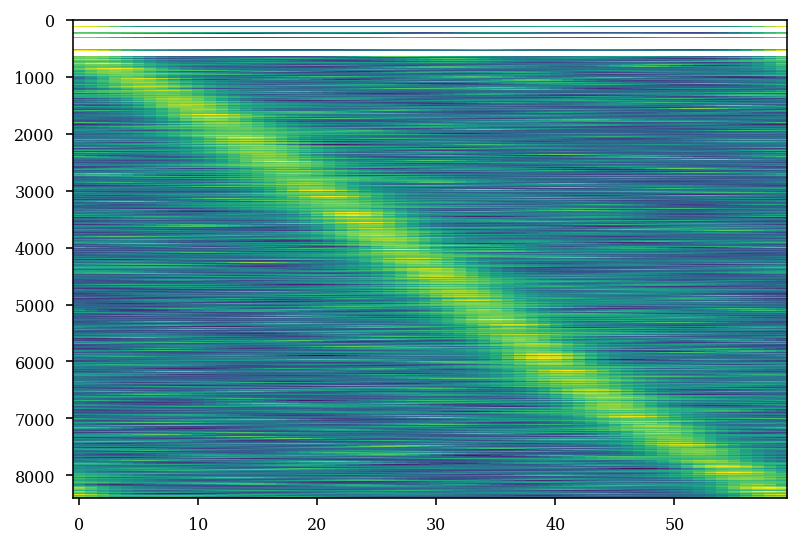

In [14]:
h0_current = mod_dict['smoothed_phase_zscore']

idx = np.argsort(np.argmax(h0_current,axis=1))

plt.imshow(h0_current[idx],aspect='auto')

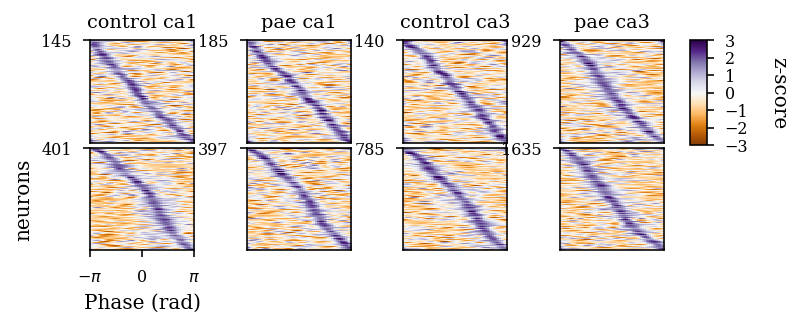

In [15]:
n_ripples = 50
n_spikes = 100

# good_cells = ((df_cell_class.n_ripples >= n_ripples) &
#               (df_cell_class.n_spikes >= n_spikes) &
#              (df_cell_class.rayleigh_pval < 0.05))

good_cells = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes))

def plot_mod_matrix(df_cell_class,mod_dict,good_cells,group,area,cell_type,ax,x_off=False):
    norm = MidpointNormalize(vmin=-3, vmax=3, midpoint=0)

    h0_current = mod_dict['smoothed_phase_zscore'][good_cells &
                           (df_cell_class.cell_type == cell_type) &
                           (df_cell_class.area == area) &
                           (df_cell_class.group == group)]
    # get and sort by mean of center 3 columns
#     center_idx = int(h0_current.shape[1]/2)
#     idx = np.mean(h0_current[:,center_idx-1:center_idx+2],axis=1)
#     idx = np.argsort(idx)

    idx = np.argsort(np.argmax(h0_current,axis=1))

    # get x axis
    extent = [-np.pi, np.pi, 0 , len(idx)]
    # plot matrix
    ax.imshow(h0_current[idx,:],aspect='auto',extent=extent,cmap=plt.get_cmap('PuOr'),norm=norm)
        
    ax.set_xticks([-np.pi ,0, np.pi])
    ax.set_xticklabels(['$-\pi$',0, '$\pi$'])
    
    ax.set_yticks([h0_current.shape[0]])
    if x_off:
        ax.axes.get_xaxis().set_ticks([])
    
# def plot_mod_mean_std(df_cell_class,mod_dict,good_cells,group,area,cell_type,ax,color):
#     h0_current = mod_dict['smoothed_phase_zscore'][good_cells &
#                        (df_cell_class.cell_type == cell_type) &
#                        (df_cell_class.area == area) &
#                        (df_cell_class.group == group)]
    
#     n_bins = 60
#     bin_edges = np.linspace(-np.pi,np.pi,n_bins+1)
#     bin_width = np.diff(bin_edges)[0]
#     bin_centers = np.linspace(-np.pi+bin_width/2 ,np.pi-bin_width/2, n_bins)
    
# #     bin_centers = np.linspace(-.5,.5,mod_dict['binned_phase_zscore'].shape[1]) 
#     m = np.nanmean(h0_current,axis=0)
# #     v = np.nanstd(h0_current,axis=0) / np.sqrt(h0_current.shape[0])
#     lower,upper = confidence_intervals(h0_current)
# #     v1 = np.nanpercentile(h0_current, 5,axis=0)
# #     v2 = np.nanpercentile(h0_current, 95,axis=0)

#     ax.plot(bin_centers,m, color = color, linewidth = 1)
#     ax.fill_between(bin_centers, lower, upper, color = color, alpha = 0.5, linewidth = 0)
#     ax.axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
#     ax.set_title(group+' '+area)
#     ax.set_xlim(-np.pi,np.pi)
#     ax.set_ylim(-0.75,0.75)
#     ax.axes.get_xaxis().set_ticks([])
    

fig, axs = plt.subplots(2,4, figsize=set_size('thesis', fraction=1, subplots=(2,4)), edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.5)
ax = axs.ravel()  

# cmap = plt.get_cmap("cool_r",2)

# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca1','int',ax[0],cmap(0))
# ax[0].set_ylabel('z-score')

# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca1','pyr',ax[0],cmap(1))

# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca1','int',ax[1],cmap(0))
# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca1','pyr',ax[1],cmap(1))

# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca3','int',ax[2],cmap(0))
# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca3','pyr',ax[2],cmap(1))

# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca3','int',ax[3],cmap(0))
# plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca3','pyr',ax[3],cmap(1))


plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca1','int',ax[0],True)
ax[0].set_title('control ca1')

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca1','pyr',ax[4])
ax[4].set_xlabel('Phase (rad)')
ax[4].set_ylabel('neurons')
ax[4].set_xticks([-np.pi , np.pi], ['$-\pi$', '$\pi$'])


plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca1','int',ax[1],True)
ax[1].set_title('pae ca1')
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca1','pyr',ax[5],True)

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca3','int',ax[2],True)
ax[2].set_title('control ca3')
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca3','pyr',ax[6],True)

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca3','int',ax[3],True)
ax[3].set_title('pae ca3')
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca3','pyr',ax[7],True)



norm = MidpointNormalize(vmin=-3, vmax=3, midpoint=0)

# norm = mpl.colors.Normalize(vmin=-0.5, vmax=4.5)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('PuOr'), norm=norm)
sm.set_array([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.83, 0.5, 0.02, 0.40])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('z-score', rotation=270, labelpad=20)
# cbar.outline.set_visible(False)

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\phase_mod.svg',dpi=300,bbox_inches='tight')


In [16]:
good_cells = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes))

df_cell_class['ripple_phase_mod'] = df_cell_class.rayleigh_pval < 0.05

group = []
area = []
cell_type = []
prop = []

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='int')
group.append('control')
area.append('ca1')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='pyr')
group.append('control')
area.append('ca1')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='int')
group.append('control')
area.append('ca3')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='pyr')
group.append('control')
area.append('ca3')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))


idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='int')
group.append('pae')
area.append('ca1')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='pyr')
group.append('pae')
area.append('ca1')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='int')
group.append('pae')
area.append('ca3')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='pyr')
group.append('pae')
area.append('ca3')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_phase_mod[good_cells & idx]) / len(df_cell_class.ripple_phase_mod[good_cells & idx]))


d = {'group': group, 'area': area, 'cell_type': cell_type, 'prop': prop }
df2 = pd.DataFrame(data=d)

df2

,group,area,cell_type,prop
0,control,ca1,int,0.151724
1,control,ca1,pyr,0.344140
2,control,ca3,int,0.457143
3,control,ca3,pyr,0.538854
4,pae,ca1,int,0.416216
5,pae,ca1,pyr,0.445844
6,pae,ca3,int,0.512379
7,pae,ca3,pyr,0.562691


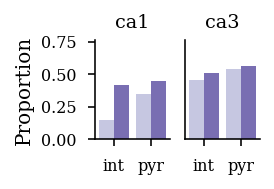

In [17]:
import seaborn as sns

f, ax = plt.subplots(1,2,figsize=set_size('thesis', fraction=0.25, subplots=(1, 1)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()

max_value = 0.76

sns.set_palette(sns.color_palette('Purples',2))
sns.barplot(x="cell_type", y="prop",hue = "group", data=df2[df2.area=='ca1'],ax=ax[0],saturation=1,alpha=1)

ax[0].legend([],[], frameon=False)
ax[0].set(ylabel="Proportion")
# sns.despine(trim=False, left=True)
ax[0].set_ylim(0,max_value)
ax[0].set_title('ca1')
ax[0].set_xlabel('')
ax[0].set_yticks(np.arange(0,max_value,.25))


sns.set_palette(sns.color_palette('Purples',2))
g = sns.barplot(x="cell_type", y="prop",hue = "group", data=df2[df2.area=='ca3'],ax=ax[1],saturation=1,alpha=1)
ax[1].legend([],[], frameon=False)
ax[1].set(ylabel="Proportion")
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylim(0,max_value)
ax[1].set_title('ca3')
# ax[1].spines["left"].set_visible(False)
sns.despine(trim=False, right=True)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\phase_proportions.svg',dpi=300,bbox_inches='tight')


In [5]:
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation_phase\post_processed\pyr_int_df.csv')
df_cell_class.head()

,Unnamed: 0,Unnamed: 0.1,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,...,peak_phase,spk_count,resultant,kappa,rayleigh_z,rayleigh_pval,group,n_ripples,ripple_phase_mod,rat
0,0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,...,-2.356194,19,0.296162,0.619889,49.148832,1.532963e-22,control,11,True,LEM3116
1,1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,...,-1.623156,1,0.952307,10.657717,35.425323,2.161190e-23,control,11,True,LEM3116
2,2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,...,-0.575959,23,0.086570,0.173713,4.845900,7.818611e-03,control,11,True,LEM3116
3,3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,...,-0.575959,2,0.644484,1.703932,24.047128,1.974152e-12,control,11,True,LEM3116
4,4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,...,2.984513,1,0.952307,10.657717,26.990722,8.454975e-18,control,11,True,LEM3116


In [32]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'pae'
    return df

good_cells = ((df_cell_class.n_ripples >= 50) &
              (df_cell_class.n_spikes >= 100) & 
              ((df_cell_class.area=='ca1') | (df_cell_class.area=='ca3')))
temp_df = df_cell_class[good_cells]

# get combo of session and area because one rat as tetrodes in multiple areas
temp_df['session_area'] = temp_df.session+temp_df.area

n_pyr = []
n_int = []
prop_pyr = []
prop_int = []
# loop through each unique session/area id
for session in pd.unique(temp_df.session_area):
    n_pyr.append(sum((temp_df.session_area == session) & (temp_df.cell_type=='pyr'))+np.finfo(float).eps)
    n_int.append(sum((temp_df.session_area == session) & (temp_df.cell_type=='int'))+np.finfo(float).eps)

    n_pyr_pass = sum((temp_df.session_area == session) & (temp_df.cell_type=='pyr') & (temp_df.ripple_phase_mod == 1))
    prop_pyr.append(n_pyr_pass / n_pyr[-1])

    n_int_pass = sum((temp_df.session_area == session) & (temp_df.cell_type=='int') & (temp_df.ripple_phase_mod == 1))
    prop_int.append(n_int_pass / n_int[-1])
    

df_prop = pd.DataFrame()

df_prop['session'] = pd.unique(temp_df.session_area)

rat = [s.split('_')[0] for s in df_prop.session]
df_prop['rat']=rat
df_prop = add_group_affiliation(df_prop)
df_prop['area'] = df_prop.session.map(lambda x: str(x)[-3:])
df_prop['session'] = df_prop.session.map(lambda x: str(x)[:-3])

df_prop['prop_pyr'] = prop_pyr
df_prop['prop_int'] = prop_int

df_prop['n_pyr'] = n_pyr
df_prop['n_int'] = n_int

df_prop.n_int = pd.to_numeric(df_prop.n_int, downcast='integer')
df_prop.n_pyr = pd.to_numeric(df_prop.n_pyr, downcast='integer')

display(df_prop.head())

df_prop.to_csv('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation_phase/post_processed/df_prop.csv')


<ipython-input-32-ddef1c15d878>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['session_area'] = temp_df.session+temp_df.area


,session,rat,group,area,prop_pyr,prop_int,n_pyr,n_int
0,LEM3116_S20180717110938,LEM3116,control,ca1,0.457831,0.083333,83,24
1,LEM3116_S20180718184628,LEM3116,control,ca1,0.600000,0.000000,20,0
2,LEM3116_S20180802100324,LEM3116,control,ca3,0.705882,0.500000,51,8
3,LEM3116_S20180803103321,LEM3116,control,ca3,0.549020,0.636364,51,11
4,LEM3116_S20180806104145,LEM3116,control,ca3,0.563636,0.500000,55,18


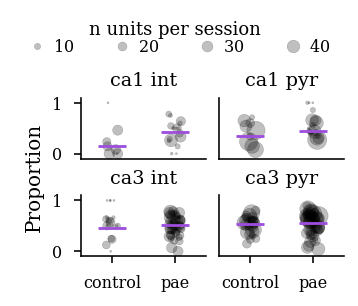

In [33]:
import seaborn as sns
def weighted_average_m1(distribution, weights):
    return sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights)

def plot_prop_custom(df_prop,y_name,w_name,ax):
    x = (df_prop.group == 'pae') * 1 + (np.random.randint(-100,100,len(df_prop))*.001)

    y = df_prop[y_name]
    h = ax.scatter(
        x,y,
        color='k',
        alpha=.25,
        s=df_prop[w_name]
    )
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='control')][y_name]),
        np.array(df_prop[(df_prop.group=='control')][w_name])
    )
    ax.scatter(0,mean,marker="_",color='#9d4edd',s=200)
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='pae')][y_name]),
        np.array(df_prop[(df_prop.group=='pae')][w_name])
    )
    ax.scatter(1,mean,marker="_",color='#9d4edd',s=200)
    
    ax.set_xlim(-.5,1.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['control','pae'])
    return h
        
fig, ax = plt.subplots(2,2,figsize=set_size('thesis', fraction=.4, subplots=(2, 2)))
fig.subplots_adjust(hspace = .6, wspace=.1)
ax = ax.ravel()

plot_prop_custom(df_prop[df_prop.area=='ca1'],'prop_int','n_int',ax[0])
plot_prop_custom(df_prop[df_prop.area=='ca1'],'prop_pyr','n_pyr',ax[1])
h0 = plot_prop_custom(df_prop[df_prop.area=='ca3'],'prop_int','n_int',ax[2])
plot_prop_custom(df_prop[df_prop.area=='ca3'],'prop_pyr','n_pyr',ax[3])

handles, labels = h0.legend_elements(num=5,prop="sizes", alpha=0.25)
legend2 = ax[1].legend(handles,
                       labels,
                       ncol=4,
                       loc='upper right',
                       bbox_to_anchor=(0.5, 2, 0.5, 0.5),
                       title="n units per session",
                       frameon=False,
                       fontsize=8,
                       labelspacing=0,
                       handletextpad=0)

plt.setp(legend2.get_title(),fontsize=9)

ax[0].set_title('ca1 int')
ax[1].set_title('ca1 pyr')
ax[2].set_title('ca3 int')
ax[3].set_title('ca3 pyr')

ax[0].set(xlabel="")
sns.despine(trim=False, right=True)

ax[0].set_ylim(-.1,1.1)
ax[1].set_ylim(-.1,1.1)
ax[2].set_ylim(-.1,1.1)
ax[3].set_ylim(-.1,1.1)

# ax[0].set_ylabel('Proportion')
fig.text(-0.04, 0.5, 'Proportion', va='center', rotation='vertical')

ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

ax[1].axes.get_yaxis().set_ticks([])
ax[3].axes.get_yaxis().set_ticks([])

ax[0].axes.get_xaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])


# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\rip_mod_prop_per_session_v2.svg',dpi=300,bbox_inches='tight')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\rip_phase_mod_prop_per_session_v2.svg',dpi=300,bbox_inches='tight')


# format data for group comparison

In [13]:
n_pyr = []
n_pyr_pass = []
n_int = []
n_int_pass = []
area = []
curr_session = []

df_cell_class['ripple_phase_mod'] = df_cell_class.rayleigh_pval < 0.05

good_cells = ((df_cell_class.n_ripples >= 50) &
              (df_cell_class.n_spikes >= 100))
temp_df = df_cell_class[good_cells]


for session in pd.unique(temp_df.session):
    
    sess_idx = temp_df.session == session
    if sum(temp_df.area[sess_idx] == 'ca1') == len(temp_df.area[sess_idx]):
        n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
        n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_phase_mod == 1)))

        n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
        n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_phase_mod == 1)))
        
        area.append('ca1')
        curr_session.append(session)

    elif sum(temp_df.area[sess_idx] == 'ca3') == len(temp_df.area[sess_idx]):
        n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
        n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_phase_mod == 1)))

        n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
        n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_phase_mod == 1)))
        
        area.append('ca3')
        curr_session.append(session)

    else:
        n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
        n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_phase_mod == 1)))

        n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
        n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_phase_mod == 1)))
        
        area.append('ca1')
        curr_session.append(session)

        n_pyr.append(sum((sess_idx) & (temp_df.cell_type=='pyr')))
        n_pyr_pass.append(sum((sess_idx) & (temp_df.cell_type=='pyr') & (temp_df.ripple_phase_mod == 1)))

        n_int.append(sum((sess_idx) & (temp_df.cell_type=='int')))
        n_int_pass.append(sum((sess_idx) & (temp_df.cell_type=='int') & (temp_df.ripple_phase_mod == 1)))
        
        area.append('ca3')
        curr_session.append(session)


In [15]:
df_prop = pd.DataFrame()

df_prop['n_pyr'] = n_pyr
df_prop['n_pyr_pass'] = n_pyr_pass
df_prop['n_int'] = n_int
df_prop['n_int_pass'] = n_int_pass

df_prop['prop_pyr'] = df_prop.n_pyr_pass / df_prop.n_pyr
df_prop['prop_int'] = df_prop.n_int_pass / df_prop.n_int

df_prop['area'] = area
df_prop['session'] = curr_session

control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df_prop['group'] = np.ones_like(df_prop.session)

regstr = '|'.join(control)
idx = df_prop['session'].str.upper().str.contains(regstr)    
df_prop.loc[idx,'group'] = 'control'

regstr = '|'.join(pae)
idx = df_prop['session'].str.upper().str.contains(regstr)    
df_prop.loc[idx,'group'] = 'pae'

rat = [s.split('_')[0] for s in df_prop.session]
df_prop['rat']=rat

display(df_prop)

df_prop.to_csv('F:/Projects/PAE_PlaceCell/analysis/ripple_modulation_phase/post_processed/df_prop.csv')


,n_pyr,n_pyr_pass,n_int,n_int_pass,prop_pyr,prop_int,area,session,group,rat
0,83,38,24,2,0.457831,0.083333,ca1,LEM3116_S20180717110938,control,LEM3116
1,20,12,0,0,0.600000,NaN,ca1,LEM3116_S20180718184628,control,LEM3116
2,51,36,8,4,0.705882,0.500000,ca3,LEM3116_S20180802100324,control,LEM3116
3,51,28,11,7,0.549020,0.636364,ca3,LEM3116_S20180803103321,control,LEM3116
4,55,31,18,9,0.563636,0.500000,ca3,LEM3116_S20180806104145,control,LEM3116
...,...,...,...,...,...,...,...,...,...,...
90,12,8,10,5,0.666667,0.500000,ca3,LEM3246_S20190807163403,pae,LEM3246
91,17,12,17,12,0.705882,0.705882,ca3,LEM3246_S20190808162933,pae,LEM3246
92,29,19,20,10,0.655172,0.500000,ca1,LS19_S20170508130713,pae,LS19
93,41,27,11,6,0.658537,0.545455,ca1,LS19_S20170515215901,pae,LS19


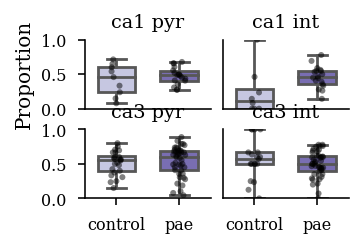

In [22]:
import seaborn as sns

fig, ax = plt.subplots(2,2,figsize=set_size('thesis', fraction=.4, subplots=(2, 2)))
fig.subplots_adjust(hspace = .3, wspace=.1)
ax = ax.ravel()

sns.set_palette(sns.color_palette('Purples',2))

sns.boxplot(x="group", y="prop_pyr", data=df_prop[df_prop.area=='ca1'],
            whis=[0, 100], width=.6,ax=ax[0],saturation=1)
sns.stripplot(x="group", y="prop_pyr",data=df_prop[df_prop.area=='ca1'],
              size=3, color="k",alpha=.5, linewidth=0,ax=ax[0])
ax[0].set_title('ca1 pyr')


sns.boxplot(x="group", y="prop_int", data=df_prop[df_prop.area=='ca1'],
            whis=[0, 100], width=.6,ax=ax[1],saturation=1)
sns.stripplot(x="group", y="prop_int",data=df_prop[df_prop.area=='ca1'],
              size=3, color="k",alpha=.5, linewidth=0,ax=ax[1])
ax[1].set_title('ca1 int')


sns.boxplot(x="group", y="prop_pyr", data=df_prop[df_prop.area=='ca3'],
            whis=[0, 100], width=.6,ax=ax[2],saturation=1)
sns.stripplot(x="group", y="prop_pyr",data=df_prop[df_prop.area=='ca3'],
              size=3, color="k",alpha=.5, linewidth=0,ax=ax[2])
ax[2].set_title('ca3 pyr')


sns.boxplot(x="group", y="prop_int", data=df_prop[df_prop.area=='ca3'],
            whis=[0, 100], width=.6,ax=ax[3],saturation=1)
sns.stripplot(x="group", y="prop_int",data=df_prop[df_prop.area=='ca3'],
              size=3, color="k",alpha=.5, linewidth=0,ax=ax[3])
ax[3].set_title('ca3 int')


ax[0].set(xlabel="")
sns.despine(trim=False, right=True)


ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[2].set_ylim(0,1)
ax[3].set_ylim(0,1)

ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')

ax[0].set_ylabel('Proportion')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

ax[1].axes.get_yaxis().set_ticks([])
# ax[2].axes.get_yaxis().set_ticks([])
ax[3].axes.get_yaxis().set_ticks([])

ax[0].axes.get_xaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\rip_phase_mod_prop_per_session.svg',dpi=300,bbox_inches='tight')


### population polar plot

In [319]:
mod_dict.keys()

dict_keys(['binned_phase', 'phase_counts', 'smoothed_phase', 'peak_phase', 'spk_count', 'resultant', 'kappa', 'rayleigh_z', 'rayleigh_pval', 'smoothed_phase_zscore', 'binned_phase_zscore'])

(0, 1)

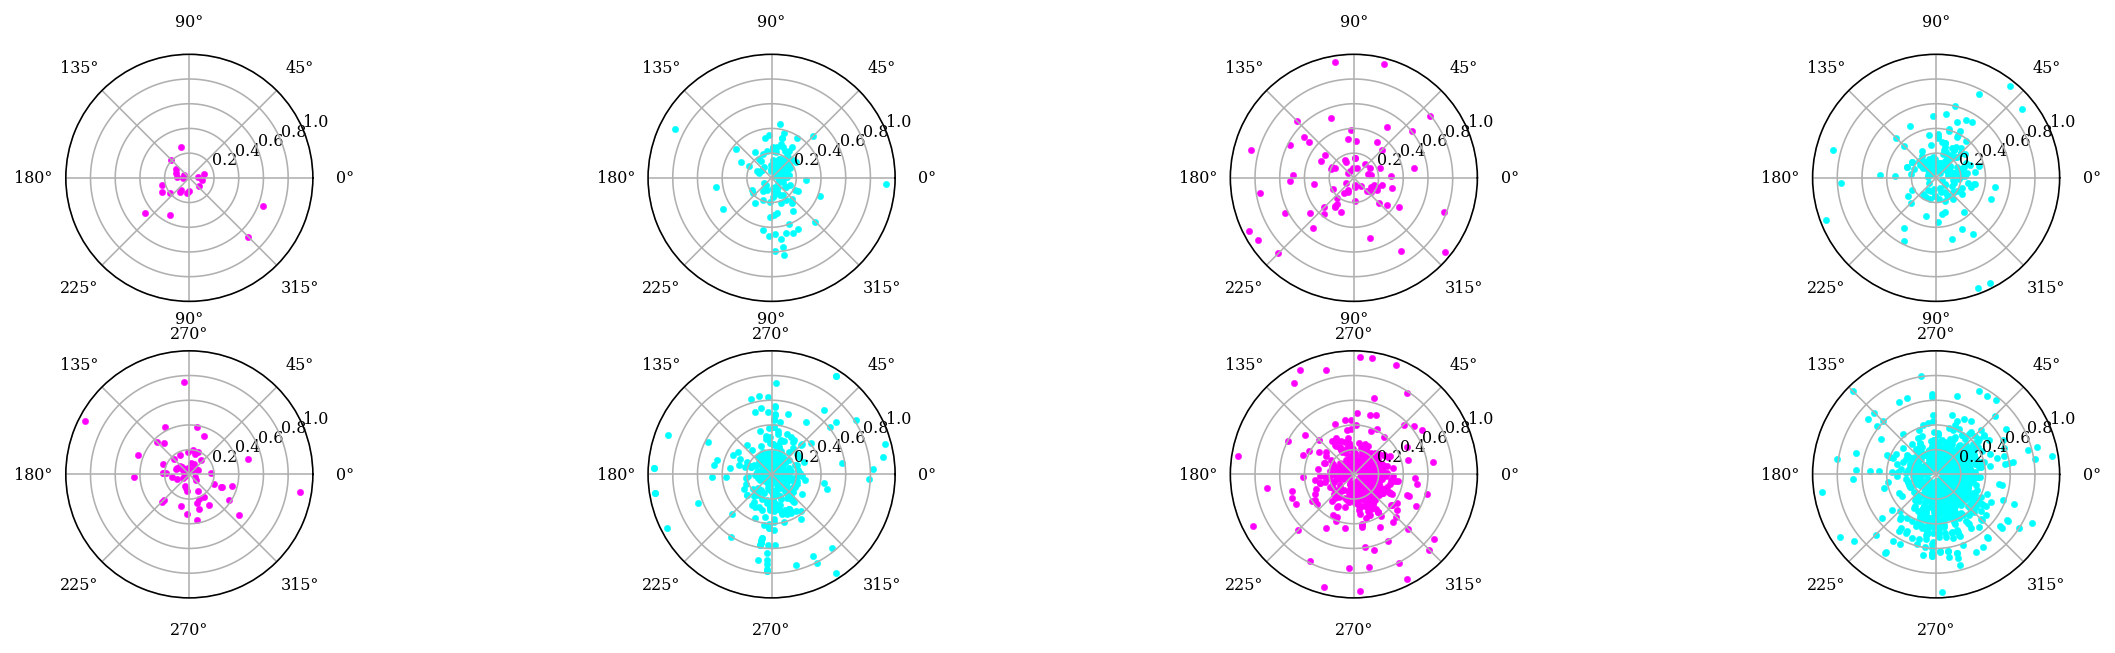

In [355]:
cmap = plt.get_cmap("cool_r",2)

plt.figure(figsize=(20,5))

gs = gridspec.GridSpec(2,4)

plt.subplot(gs[0,0], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'int') &
              (df_cell_class.group == 'control') &
              (df_cell_class.area == 'ca1'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(0),s=10)
plt.ylim(0,1)

plt.subplot(gs[0,1], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'pyr') &
              (df_cell_class.group == 'control') &
              (df_cell_class.area == 'ca1'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(1),s=10)
plt.ylim(0,1)

plt.subplot(gs[0,2], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'int') &
              (df_cell_class.group == 'pae') &
              (df_cell_class.area == 'ca1'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(0),s=10)
plt.ylim(0,1)

plt.subplot(gs[0,3], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'pyr') &
              (df_cell_class.group == 'pae') &
              (df_cell_class.area == 'ca1'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(1),s=10)
plt.ylim(0,1)



plt.subplot(gs[1,0], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'int') &
              (df_cell_class.group == 'control') &
              (df_cell_class.area == 'ca3'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(0),s=10)
plt.ylim(0,1)

plt.subplot(gs[1,1], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'pyr') &
              (df_cell_class.group == 'control') &
              (df_cell_class.area == 'ca3'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(1),s=10)
plt.ylim(0,1)

plt.subplot(gs[1,2], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'int') &
              (df_cell_class.group == 'pae') &
              (df_cell_class.area == 'ca3'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(0),s=10)
plt.ylim(0,1)

plt.subplot(gs[1,3], projection = 'polar')

idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) &
              (df_cell_class.cell_type == 'pyr') &
              (df_cell_class.group == 'pae') &
              (df_cell_class.area == 'ca3'))
plt.scatter(mod_dict['peak_phase'][idx],mod_dict['resultant'][idx],color=cmap(1),s=10)
plt.ylim(0,1)

# Individual examples

In [121]:
max_idx = [np.argmax(np.abs(w)) for w in waveforms]

peaks = []
for w in waveforms:
    peak,_ = find_peaks(w)
    peaks.append(peak)
to_flip = [np.any((w >= 28-1) & (w<=28+1)) for w in peaks]
waveforms_flipped = waveforms.copy()
waveforms_flipped[to_flip] = waveforms_flipped[to_flip]*-1

In [134]:
fig_save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/'

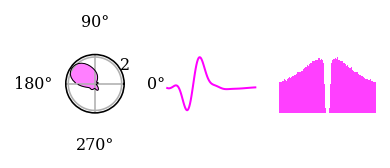

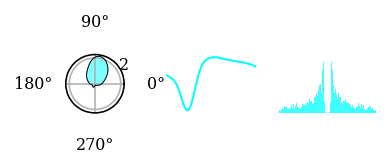

In [182]:


def plot_polar_example(df_cell_class,mod_dict,group,area,cell_type,color,cell=0):
    
    good_cells = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) & 
             (df_cell_class.group == group) &
             (df_cell_class.area == area) &
             (df_cell_class.cell_type == cell_type))
    
    plt.figure(figsize=set_size('thesis', fraction=0.5, subplots=(1,1)))

    gs = gridspec.GridSpec(3,3)

    plt.subplot(gs[0,0], projection = 'polar')
    lines, labels = plt.thetagrids(range(0, 360, int(360/4)))
    r = mod_dict['smoothed_phase_zscore'][good_cells][cell]
    plt.plot(bin_centers, r, color='k',linewidth=.5) 
    plt.fill(bin_centers,r, color=color,alpha=.5)
    plt.yticks([int(max(r))])
    plt.grid('off')

    plt.subplot(gs[0,1])
    plt.plot(waveforms_flipped[good_cells][cell],color=color,linewidth=1)
    plt.axis('off')

    plt.subplot(gs[0,2])
    x = np.linspace(-0.05,0.05,acg[good_cells][cell].shape[0])
    plt.bar(x,acg[good_cells][cell],color=color,width=0.0005,alpha=.75)
    # plt.plot(x,acg[good_cells][cell],color='k',linewidth=.5)
    plt.xlim(-0.05,0.05)
    plt.axis('off')

    ids = (df_cell_class[good_cells].iloc[cell].group +
           df_cell_class[good_cells].iloc[cell].area +
           df_cell_class[good_cells].iloc[cell].cell_type)

    plt.savefig(fig_save_path + ids + '.svg',dpi=300,bbox_inches='tight')

cmap = plt.get_cmap("cool_r",2)
  
plot_polar_example(df_cell_class,mod_dict,'control','ca1','int',cmap(0),cell=18)

plot_polar_example(df_cell_class,mod_dict,'control','ca1','pyr',cmap(1),cell=3)

In [220]:
idx = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes) &
             (df_cell_class.rayleigh_pval < 0.05) & 
             (df_cell_class.group == 'control') &
             (df_cell_class.area == 'ca1') &
             (df_cell_class.cell_type == 'int'))

df_cell_class[idx].iloc[18]


Unnamed: 0                                    5681
session                    LEM3216_S20190720145517
tetrode                                   TT11.mat
cell                                             5
acg_tau_decay                              93.0363
acg_tau_rise                               1.09643
acg_c                                      112.242
acg_d                                      1.12079
acg_asymptote                             -24.6681
acg_refrac                                  2.1312
acg_tau_burst                              1.09766
acg_h                                      32.4402
acg_fit_rsquare                           0.992437
thetaModulationIndex                      0.200256
burstIndex_Royer2012                       1.24559
burstIndex_Doublets                        1.00855
polarity                                 -0.314337
peaktoTrough                              0.140625
troughtoPeak                              0.296875
derivative_TroughtoPeak        

In [ ]:
session = 'LEM3216_S20190720145517'
df_swr = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')

# find index of first mention of session
rip_n = np.where(df_swr.session == session)[0][0]
# load spikes
spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# get ripple times
peak_time = df_swr.peak_time[df_swr.session == session]
# get session range
spikes_ = list(itertools.chain(*spikes))
session_range = [min(spikes_),max(spikes_)]

def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

path = get_session_path(data_path+session+'.mat')

# load xml which has channel & fs info
channels,fs,shank = loadXML(path)

# get good channels
good_ch = get_good_channels(shank)

lfp,lfp_ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                 channel=good_ch, frequency=fs)


In [244]:
phase = np.stack([phase_by_time(lfp_,fs,f_range=(80,250),remove_edges=False) for lfp_ in lfp.T])
phase = phase.T

In [356]:
sig_filt = np.stack([filter_signal(lfp_,fs,'bandpass',(80,250),remove_edges=False) for lfp_ in lfp.T])
sig_filt = sig_filt.T

# sig_filt = filter_signal(sig, fs, 'bandpass', f_range)


In [ ]:
# 134825
# for i,s in enumerate(spikes):
#     print(i,'  ',len(s))

In [357]:
event = df_swr[df_swr.session == session].iloc[11]

start = event.start_time - 0.1
end = event.end_time + 0.1

# current lfp
current_lfp = lfp[(lfp_ts > start) & (lfp_ts < end),event.peak_channel]
current_lfp_ts = lfp_ts[(lfp_ts > start) & (lfp_ts < end)]
current_phase = phase[(lfp_ts > start) & (lfp_ts < end),event.peak_channel]
current_sig_filt = sig_filt[(lfp_ts > start) & (lfp_ts < end),event.peak_channel]


# current spikes
current_spikes = spikes[10].copy()

current_spikes = current_spikes[(current_spikes > start) & (current_spikes < end)]

spike_phase = circ_interp(current_lfp_ts,current_phase,current_spikes)

In [304]:


cmap = plt.get_cmap('hsv',360)
cmap(0)
# spike_phase

(1.0, 0.0, 0.0, 1.0)

Text(0.5, 0, 'time (sec)')

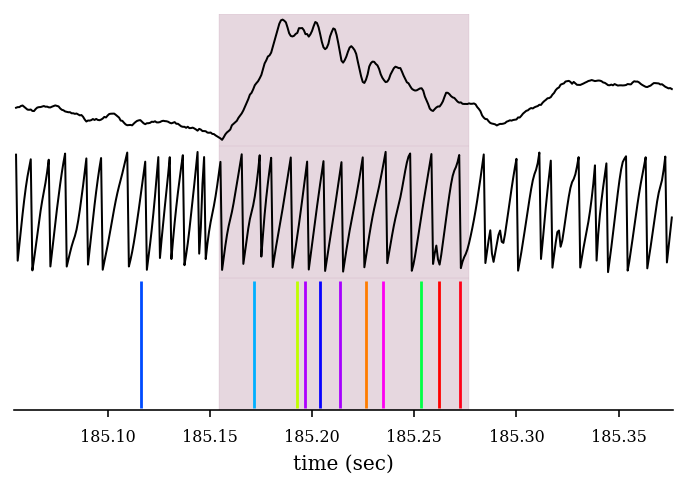

In [359]:

w,l = set_size('thesis', fraction=1, subplots=(1, 1))

# fig, axs = plt.subplots(3,1, figsize=(w - 2,1.5), edgecolor='k')
fig, axs = plt.subplots(3,1, figsize=set_size('thesis', fraction=1, subplots=(1, 1)), edgecolor='k')

fig.subplots_adjust(hspace = 0, wspace=0)
ax = axs.ravel()

ax[0].plot(current_lfp_ts,current_lfp,'k',linewidth=1)
ax[0].set_xlim(start,end)
ax[0].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
ax[0].axis('off')

ax[1].plot(current_lfp_ts,current_phase,'k',linewidth=1)
ax[1].set_xlim(start,end)
ax[1].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
ax[1].axis('off')

# ax[2].eventplot(current_spikes,color='k',linewidths=2,linelengths=1.5)
ax[2].scatter(current_spikes,np.ones_like(current_spikes),s=4000,c=spike_phase,marker="|",cmap='hsv')
# ax[1].set_ylim(-.5,len(location)-sum(np.isnan(location)))
ax[2].axvspan(event.start_time, event.end_time, alpha=0.2, color='#843b62', zorder=-1000)
ax[2].set_xlim(start,end)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].axes.get_yaxis().set_ticks([])

# ax[2].set_ylabel('neurons')
ax[2].set_xlabel('time (sec)')

# testing below

In [ ]:
session = 'LEM3206_S20190720132154'
path = get_session_path(data_path+session+'.mat')

# load xml which has channel & fs info
channels,fs,shank = loadXML(path)

# get good channels
good_ch = get_good_channels(shank)

lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                 channel=good_ch, frequency=fs)

phase = np.stack([phase_by_time(lfp_,fs,f_range=(80,250),remove_edges=False) for lfp_ in lfp.T])
phase = phase.T

In [ ]:
spikes = get_spikes(data_path+session+'.mat')

In [ ]:
n_spikes = [s.shape for s in spikes]

np.argmax(n_spikes)

In [ ]:
spk_phase = []
occ_phase = []

spk = spikes[14]

for ripple in df[df.session == session].itertuples():
    # restrict spikes to current ripple
    current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
    # collect interp phase for each spike
    spk_phase.append(np.interp(current_spikes,ts,phase[:,int(ripple.peak_channel)]))

    # collect occ phases for normalization
    occ_phase.append(phase[(ts >= ripple.peak_time - 0.1) & (ts <= ripple.peak_time + 0.1),int(ripple.peak_channel)])

x1 = list(itertools.chain(*spk_phase)) 



spk_phase = []
occ_phase = []

for ripple in df[df.session == session].itertuples():
    # restrict spikes to current ripple
    current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
    # collect interp phase for each spike
#     spk_phase.append(np.interp(current_spikes,ts,phase[:,int(ripple.peak_channel)]))
    # pull out phases
    theta = phase[:,int(ripple.peak_channel)]
    # get sin and cos then interp spike times
    spk_phase_ = np.arctan2(np.interp(current_spikes,ts,np.sin(theta)), np.interp(current_spikes,ts,np.cos(theta)))
    # wrap -pi to pi
    spk_phase_ = (spk_phase_ + np.pi) % (2 * np.pi) - np.pi
    spk_phase.append(spk_phase_)

    # collect occ phases for normalization
    occ_phase.append(phase[(ts >= ripple.peak_time - 0.1) & (ts <= ripple.peak_time + 0.1),int(ripple.peak_channel)])

x2 = list(itertools.chain(*spk_phase)) 


from scipy import interpolate
spk_phase = []
occ_phase = []
for ripple in df[df.session == session].itertuples():
    # restrict spikes to current ripple
    current_spikes = spk[(spk >= ripple.peak_time - 0.1) & (spk <= ripple.peak_time + 0.1)]
    # collect interp phase for each spike
#     spk_phase.append(np.interp(current_spikes,ts,phase[:,int(ripple.peak_channel)]))
    
    f = interpolate.interp1d(ts, phase[:,int(ripple.peak_channel)],kind='nearest')
    spk_phase.append(f(current_spikes))
    
    # collect occ phases for normalization
    occ_phase.append(phase[(ts >= ripple.peak_time - 0.1) & (ts <= ripple.peak_time + 0.1),int(ripple.peak_channel)])

x3 = list(itertools.chain(*spk_phase)) 


In [ ]:
plt.plot(x1,'.k')
plt.plot(x2,'.r')

plt.figure()
plt.scatter(x1,x2)

plt.figure()
plt.scatter(x2,x3)

In [ ]:
n_bins = 60
bin_edges = np.linspace(-np.pi,np.pi,n_bins+1)
bin_width = np.diff(bin_edges)[0]
bin_centers = np.linspace(-np.pi+bin_width/2 ,np.pi-bin_width/2, n_bins)
y, _ = np.histogram(x1, bins=bin_edges)

plt.plot(y)

y, _ = np.histogram(x2, bins=bin_edges)
plt.plot(y)

y, _ = np.histogram(x3, bins=bin_edges)
plt.plot(y)

In [ ]:
# theta = (position_df.hd * (np.pi / 180))
theta = phase[:,int(ripple.peak_channel)]
plt.figure()
plt.plot(theta[0:220])
plt.figure()
phases = np.arctan2(np.sin(theta), np.cos(theta))
# phases = (2*np.pi + phases) * (phases < 0) + phases*(phases > 0)

phases = (phases + np.pi) % (2 * np.pi) - np.pi
plt.plot(phases[0:220])